In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from eth_utils import humanize_hash, to_bytes
from web3 import Web3, HTTPProvider
from dotenv import load_dotenv
from clr import *

In [2]:
simulation = False
 
if simulation: # randomly generate projects, backers, and contribution amounts for simulation and testing
    n_backers = 40
    n_contribs = int(n_backers * 2.5)

    contr_distr = [1, 2, 4, 8, 16] # exponential distribution
    big_contr_distr = [i * 10**18 for i in contr_distr]

    project_ids = ['pizza']*4 + ['bonding_curve'] + ['tcr']*3 + ['unisocks_fork'] + ['pool_together']*6
    backer_ids = ['0x' + str(i) for i in range(10000000, 10000000 + n_backers)]

    # create clr() input lists
    projects = random.choices(project_ids, k = n_contribs)
    backers = random.choices(backer_ids, k = n_contribs)
    contribution_amounts = random.choices(big_contr_distr, k = n_contribs)
    
else: # read contribution data from the smart contract
    # set these manually each time there's a new contract
    network = 'mainnet' 
    testnet_address = '0xd3400d09306fB21008cF9df99F7678fF73df6145'
    mainnet_address = '0xaD4a34A7854138d6A8A0254F793AC3510090e9e5'
    if network != 'mainnet':
        raw_address = testnet_address
    else:
        raw_address = mainnet_address
    
    eth_chicago_QF_contract_address = Web3.toChecksumAddress(raw_address)

    # get infura project id from .env (to avoid revealing publicly on github)
    load_dotenv()
    infura_project_id = os.getenv("INFURA_PROJECT_ID")
    
    # set up connection to infura
    infura_url = 'https://' + network + '.infura.io/v3/' + infura_project_id
    w3 = Web3(Web3.HTTPProvider(infura_url))
    
    # get the contract abi from the contract-project directory
    with open('../../quadratic-funding/contract-project/abis/EthChicagoQF.json') as file:
        abi_json = json.load(file)
    eth_chicago_QF_contract_abi = abi_json
    
    # create the contract object
    eth_chicago_QF_contract = w3.eth.contract(address = eth_chicago_QF_contract_address, 
                                              abi = eth_chicago_QF_contract_abi)
    
    # get project names from the contract
    project_count = eth_chicago_QF_contract.functions.getProjectCount().call()
    project_names = []
    
    for index in range(project_count):
        project = eth_chicago_QF_contract.functions.getProjectNicknameAtIndex(index).call()
        project_names.append(project)

    # create clr() input lists
    projects = []
    backers = []
    contribution_amounts = []

    for project in project_names:
        contribution_count = eth_chicago_QF_contract.functions.getContributionCount(project).call()
        for index in range(contribution_count):
            projects.append(project)

            backer = eth_chicago_QF_contract.functions.getBackerAtIndex(project, index).call()
            backers.append(backer)

            amount = eth_chicago_QF_contract.functions.getAmountAtIndex(project, index).call()
            contribution_amounts.append(amount)

In [3]:
# set matching budget
match_budget = 400

# calculate matches
grants, lr_matches, clr_matches = clr(projects, backers, contribution_amounts, match_budget)

In [4]:
# create tidy dataframe with all data
# columns: project, backer, contribution, backer_total, project_grant, LR_match, CLR_match
# rows: unique observations

df = pd.DataFrame.from_dict(grants) \
    .rename_axis('backer').reset_index() \
    .melt(id_vars = ['backer'], value_name = 'contribution_amount') \
    .rename(columns = {'variable':'project'}) \
    .dropna().reset_index(drop = True) \
    .assign(backer_short = lambda d: d['backer'].map(lambda backer: humanize_hash(to_bytes(hexstr = backer))),
            backer_total_contribution = lambda d: d.groupby('backer')['contribution_amount'].transform('sum'),
            project_total_contribution = lambda d: d.groupby('project')['contribution_amount'].transform('sum'),
            LR_match = lambda d: d['project'].map(lambda project: lr_matches[project]),
            CLR_match = lambda d: d['project'].map(lambda project: clr_matches[project])
           ) \
    .sort_values(by = 'backer_total_contribution', ascending = False)

df['project_total_grant'] = df.project_total_contribution + df.CLR_match
df['contribution_match'] = (df.contribution_amount / df.project_total_contribution) * df.CLR_match
df['matching_ratio'] = df.contribution_match / df.contribution_amount

In [5]:
# tidy dataframe at the recipient level
by_recip = df.groupby('project').max().drop(['backer',
                                                   'backer_short', 
                                                   'backer_total_contribution',
                                                   'contribution_amount',
                                                   'contribution_match'], axis = 1)
by_recip['contribution_count'] = df.groupby('project')['contribution_amount'].count()
by_recip['mean_contribution'] = df.groupby('project')['contribution_amount'].mean()
by_recip['median_contribution'] = df.groupby('project')['contribution_amount'].median()
by_recip = by_recip.sort_values(by = 'project_total_grant', ascending = False)

# dataframe with rounded values for presentation
rounded = by_recip.round(2).round({'contribution_count': 0})

In [6]:
# setup plotting
%matplotlib inline
sns.set(style = 'darkgrid', context = 'talk')

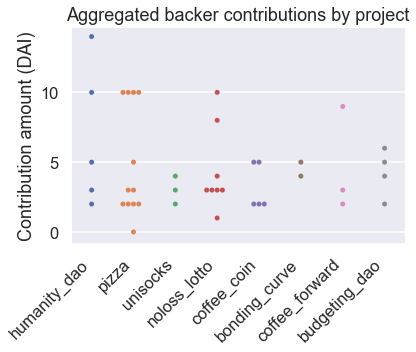

In [7]:
# plot contributions by recipient
ax = sns.swarmplot(x = 'project', y = 'contribution_amount', dodge = False, data = df)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('Contribution amount (DAI)')
ax.set_title('Aggregated backer contributions by project') ;

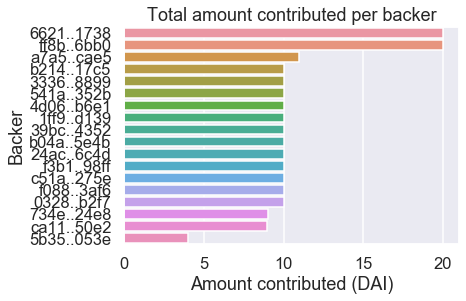

In [8]:
ax = sns.barplot(data = df, y = 'backer_short', x = 'backer_total_contribution', orient = 'h') 
ax.set_xlabel('Amount contributed (DAI)')
ax.set_ylabel('Backer')
ax.set_title('Total amount contributed per backer') ;

In [9]:
rounded

,project_total_contribution,LR_match,CLR_match,project_total_grant,matching_ratio,contribution_count,mean_contribution,median_contribution
project,,,,,,,,
pizza,59.00,576.43,191.42,250.42,3.24,12,4.92,3.0
noloss_lotto,35.00,253.41,84.15,119.15,2.40,8,4.38,3.0
humanity_dao,34.00,150.95,50.13,84.13,1.47,5,6.80,5.0
coffee_coin,16.00,75.95,25.22,41.22,1.58,5,3.20,2.0
budgeting_dao,17.00,65.61,21.79,38.79,1.28,4,4.25,4.5
coffee_forward,13.99,37.76,12.54,26.53,0.90,3,4.66,3.0
unisocks,9.00,26.48,8.79,17.79,0.98,3,3.00,3.0
bonding_curve,9.00,17.94,5.96,14.96,0.66,2,4.50,4.5


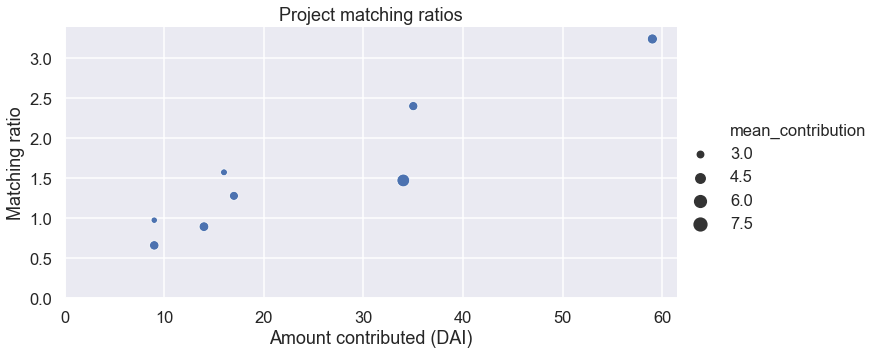

In [10]:
# plot clr matches by project total contribution by mean contribution
ax = sns.relplot(data = by_recip, x = 'project_total_contribution', y = 'matching_ratio', 
                size = 'mean_contribution', height = 5, aspect = 2)
ax.set(xlabel = 'Amount contributed (DAI)', 
       ylabel = 'Matching ratio',
       title = 'Project matching ratios',
       xlim = 0,
       ylim = 0
      )  ;

In [11]:
# #plot grant sums by number of funders by recipient
# sns.relplot(x = 'contribution_count', y = 'CLR_match', size = 'project_total_contribution', data = by_recip,
#            height = 5, aspect = 2) ;

In [12]:
# #plot clr match by project total contribution by mean contribution
# sns.relplot(x = 'project_total_contribution', y = 'CLR_match', size = 'mean_contribution', data = by_recip,
#            height = 5, aspect = 2) ;

In [13]:
# #plot contribution amount against contribution match amount, colored by project
# sns.relplot(data = df, x = 'contribution_amount', y = 'contribution_match', hue = 'project',
#            height = 5, aspect = 2) ;

In [14]:
marginal = pd.DataFrame(columns = ['project', 'marginal_contribution', 'marginal_match', 'old_clr', 'new_clr'])

for project in set(project_names):
    max_contrib = 1024 # find better name for amount
    
    old_match = clr_matches[project]
    
    new_projects = projects + [project]
    
    for i in range(0, max_contrib):
        new_contrib = i
        nc_bigunits = new_contrib * 10**18
        
        new_backers = backers + ['0x10000099']        
        new_contribs = contribution_amounts + [nc_bigunits]
        
        new_grants, new_lr, new_clr = clr(new_projects, new_backers, new_contribs, match_budget)
        new_match = new_clr[project]
        marginal_match = new_match - old_match
        
        to_add = pd.DataFrame([[project, new_contrib, marginal_match, old_match, new_clr[project]],], 
                              columns=['project', 
                                        'marginal_contribution',
                                        'marginal_match',
                                        'old_clr',
                                        'new_clr'])
        marginal = marginal.append(to_add, ignore_index = True)

        
    

In [15]:
# ax = sns.relplot(data = marginal, x = 'marginal_contribution', y = 'marginal_match', hue = 'project', 
#             kind = 'line', height = 8, aspect = 1.5)
# ax.set(xlabel = 'Amount contributed (DAI)', 
#        ylabel = 'Additional matched funds directed (DAI)',
#        title = 'Individual Leverage Curves'
#       ) ;

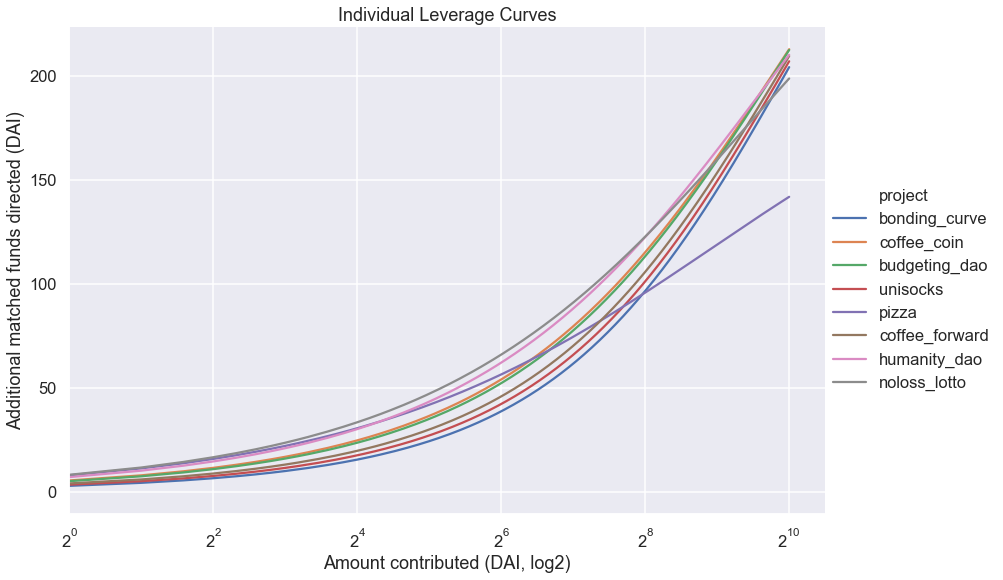

In [16]:
ax = sns.relplot(data = marginal, x = 'marginal_contribution', y = 'marginal_match', hue = 'project', 
            kind = 'line', height = 8, aspect = 1.5)
ax.set(xlabel = 'Amount contributed (DAI, log2)', 
       ylabel = 'Additional matched funds directed (DAI)',
       title = 'Individual Leverage Curves'
      )
plt.xscale('log', basex=2) 
plt.xlim(2**0) ;